# Introduction


In this version of my notebook, I have used the ensemble method using Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

This Notebook follows three main parts:
* The data preparation
* The CNN modeling and evaluation
* The results prediction and submission

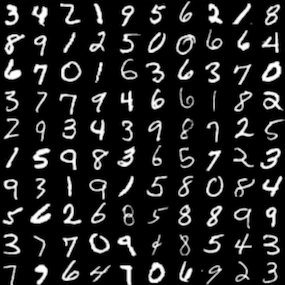

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


sns.set(style='white', context='notebook', palette='deep')

# 2. Data preparation
## 2.1 Load data

In [ ]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [ ]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

We have similar counts for the 10 digits.

## 2.2 Check for null and missing values

In [ ]:
# Check the data
X_train.isnull().any().describe()

In [ ]:
test.isnull().any().describe()

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

## 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [ ]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 2.3 Reshape

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices. 

## 2.5 Label encoding

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.6 Split training and valdiation set 

In [ ]:
# Set the random seed
random_seed = 2

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

I chose to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation. 

To avoid that, you could use stratify = True option in train_test_split function (**Only for >=0.17 sklearn versions**).

We can get a better sense for one of these examples by visualising the image and looking at the label.

In [ ]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# 3. CNN
## 3.1 Define the model

Here I have followed the ensemble method to train the model and used the Keras Sequential API, where you have just to add one layer at a time, starting from the input. 

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 5
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, padding='same', activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    #model[j].add(MaxPooling2D(pool_size=(2, 2)))
    #model[j].add(Conv2D(32, kernel_size = 3, padding='same', activation='relu'))
   # model[j].add(BatchNormalization())
    #model[j].add(MaxPooling2D(pool_size=(2, 2)))
    model[j].add(Conv2D(32, kernel_size = 3, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
   # model[j].add(MaxPooling2D(pool_size=(2, 2)))
    #model[j].add(Conv2D(64, kernel_size = 3, padding='same', activation='relu'))
    #model[j].add(BatchNormalization())
   # model[j].add(MaxPooling2D(pool_size=(2, 2)))
    model[j].add(Conv2D(64, kernel_size = 5, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    model[j].add(Dropout(0.25))

    model[j].add(Conv2D(128, kernel_size = 4, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    
    model[j].add(Flatten())
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(0.7))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## 3.3 Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important : 
   - Without data augmentation i obtained an accuracy of 98.114%
   - With data augmentation i achieved 99.67% of accuracy

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        shear_range = 0.2, #Randomly shears images
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

For the data augmentation, i choosed to :
   - Randomly rotate some training images
   - Randomly  Zoom some training images
   - Randomly shift images horizontally
   - Randomly shift images vertically
   
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset and during training, we save the models and use the best model to perform prediction.

In [ ]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 25
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=32),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//32, verbose = 2,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer])
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

# Prediction

**Here among all the models, the best performing model is estracted to perform the prediction.**

In [ ]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

**This cell of code shows the accuracy curves for all models.**

In [ ]:
for j in range(nets):
    accs = history[j].history['accuracy']
    val_accs = history[j].history['val_accuracy']

    plt.title("For CNN: "+ str(j+1))
    plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
    plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

**This cell of code shows the loss curves for all models.**

In [ ]:
for j in range(nets):
    loss = history[j].history['loss']
    val_loss = history[j].history['val_loss']

    plt.title("For CNN: "+ str(j+1))
    plt.plot(range(len(loss)),loss, label = 'Training_loss')
    plt.plot(range(len(loss)),val_loss, label = 'Validation_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()



** you found this notebook helpful or you just liked it , some upvotes would be very much appreciated - That will keep me motivated :)**
